In [70]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Set a distinct plotting style
sns.set_theme(style="whitegrid", palette="coolwarm")
plt.rcParams['figure.figsize'] = (10, 6)


In [71]:
# 1. Data Loading and Exploration
# Load the Credit Card Fraud dataset (ensure 'creditcard.csv' is available in your working directory)
df = pd.read_csv("/content/creditcard.csv")
print("Dataset shape:", df.shape)
print("\nDataset preview:")
df.head()

Dataset shape: (284807, 31)

Dataset preview:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [72]:
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21

In [73]:
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [74]:
# 2. Data Preprocessing
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

In [75]:
# Scale the 'Amount' feature (PCA features are already scaled)
scaler = StandardScaler()
X['Amount_scaled'] = scaler.fit_transform(X[['Amount']])
X = X.drop(columns=['Amount'])

# (Optional) Check distribution of target
print("\nTarget distribution:")
print(y.value_counts())



Target distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [76]:
# 3. Train-Test Split
# We use stratified splitting since the dataset is imbalanced
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (227845, 30)
Test set shape: (56962, 30)


In [77]:
# 4. Model Building with Isolation Forest
# IsolationForest is an unsupervised model for anomaly detection.
# We set contamination to the expected fraction of fraud (about 0.01 based on typical datasets).
iso_model = IsolationForest(contamination=0.01, random_state=42)
# Fit the model on the training set (IsolationForest is unsupervised)
iso_model.fit(X_train)


IsolationForest(contamination=0.01, random_state=42)

In [78]:
# 5. Model Evaluation
# Predict anomaly scores on the test set
y_pred_scores = iso_model.decision_function(X_test)
y_pred = iso_model.predict(X_test)
# Convert predictions: IsolationForest returns 1 for normal, -1 for anomaly.
# We convert anomalies to 1 (fraud) and normal to 0.
y_pred_binary = np.where(y_pred == 1, 0, 1)

In [79]:
# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.66      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.83      0.59     56962
weighted avg       1.00      0.99      0.99     56962



In [80]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

Confusion Matrix:
[[56311   553]
 [   33    65]]


In [81]:
# ROC Curve and AUC (note: lower decision_function values indicate anomalies, so we negate scores)
fpr, tpr, thresholds = roc_curve(y_test, -y_pred_scores)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9543364475784686


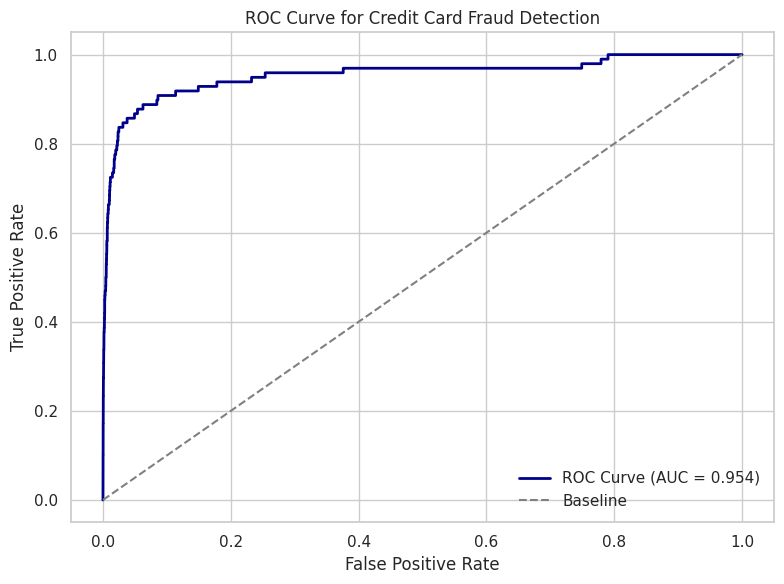

In [82]:
## 6.1 ROC Curve (Matplotlib)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkblue', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Credit Card Fraud Detection")
plt.legend()
plt.tight_layout()
plt.show()


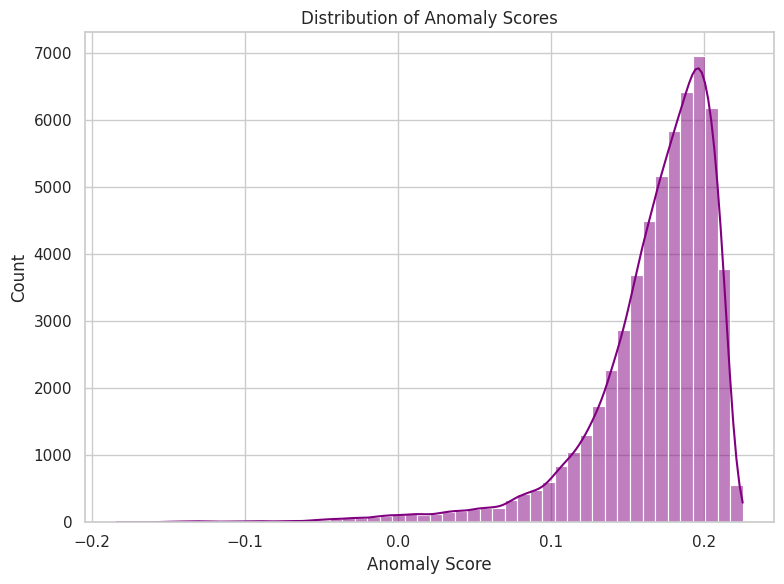

In [83]:
## 6.2 Histogram of Anomaly Scores
plt.figure(figsize=(8,6))
sns.histplot(y_pred_scores, bins=50, kde=True, color='purple')
plt.xlabel("Anomaly Score")
plt.title("Distribution of Anomaly Scores")
plt.tight_layout()
plt.show()


In [ ]:
## 6.3 3D Scatter Plot of Test Data
# Visualize two PCA features (V1 and V2) and the scaled Amount as a third dimension
fig = px.scatter_3d(
    X_test, x='V1', y='V2', z='Amount_scaled',
    color=y_pred_binary.astype(str),
    title="3D Scatter Plot: V1 vs. V2 vs. Scaled Amount",
    labels={'color': 'Predicted Fraud (0=Normal, 1=Fraud)'}
)
fig.show()

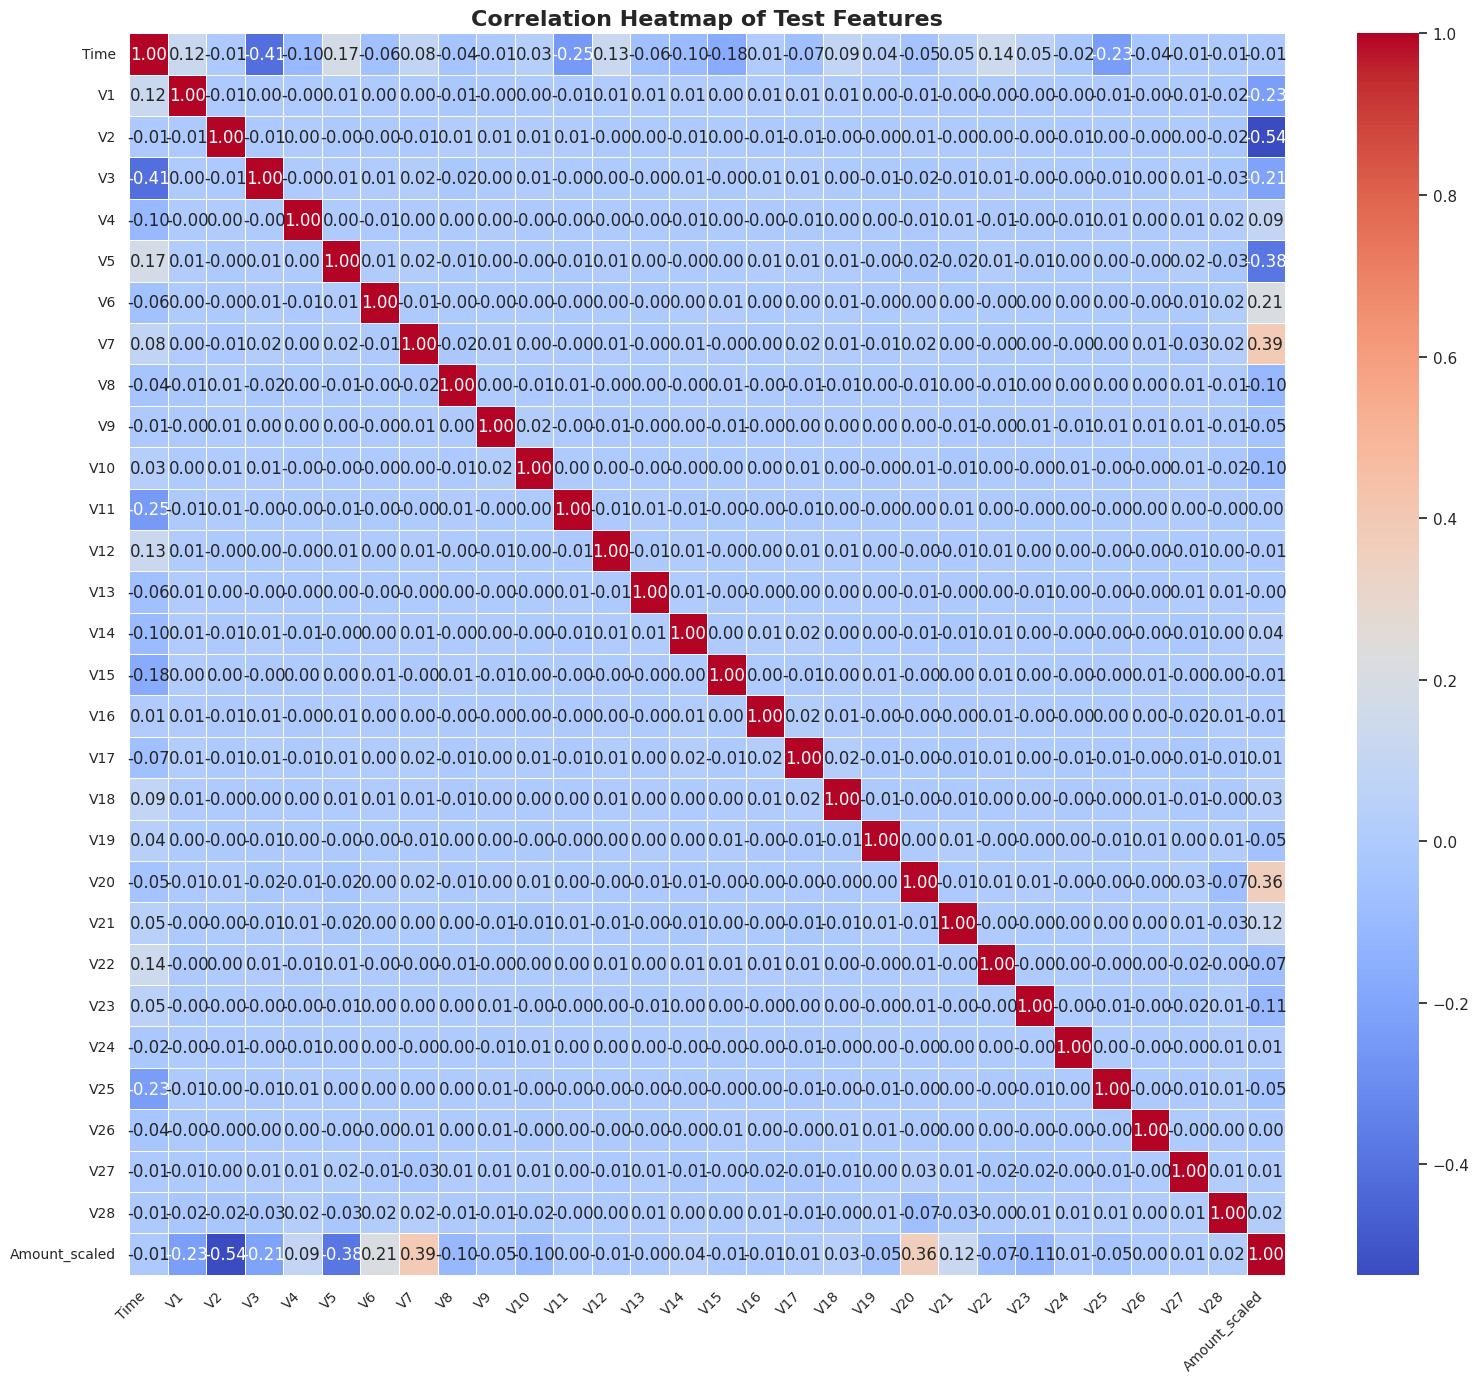

In [90]:
## 6.4 Additional: Correlation Heatmap of Test Features
corr = X_test.corr()
plt.figure(figsize=(16,14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Test Features", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()